In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import DatasetDict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.nn.functional import cross_entropy
from transformers import (
    AutoModelForSequenceClassification,
    DistilBertTokenizer,
    Trainer,
    TrainingArguments,
)

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# YELP Dataset
# source: https://huggingface.co/datasets/yelp_review_full/viewer/yelp_review_full/train?f%5blabel%5d%5bvalue%5d=0

# dataset
yelp_hidden_states = joblib.load("model/yelp_hidden_states.joblib")

In [5]:
# Model and Tokenizer
model_name = "distilbert-base-uncased"
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)
model.to(device)  # Move the model to GPU if available
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [6]:
# Dataset
train_ds = yelp_hidden_states.select(range(0, 800))
eval_ds = yelp_hidden_states.select(range(800, 1000))
print(train_ds[0]["input_ids"].shape)
print(eval_ds[0]["input_ids"].shape)
print(yelp_hidden_states[800]["input_ids"].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])


In [7]:
# DatasetDict
yelp_ds_dict = DatasetDict({"train": train_ds, "test": eval_ds})

In [8]:
# Trainer Arguments
batch_size = 8  # adapt BS to fit into memory
training_args = TrainingArguments(
    output_dir="./results",  # output directory
    learning_rate=2e-5,  # learning rate
    num_train_epochs=20,  # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy="epoch",
    log_level="error",
    weight_decay=0.01,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
    no_cuda=False if torch.cuda.is_available() else True,  # Use GPU if available
)

In [9]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_ds_dict["train"],
    eval_dataset=yelp_ds_dict["test"],
)
trainer.train()

Step,Training Loss
500,1.265500
1000,0.304600
1500,0.034300
2000,0.004200


TrainOutput(global_step=2000, training_loss=0.4021230858564377, metrics={'train_runtime': 891.2009, 'train_samples_per_second': 17.953, 'train_steps_per_second': 2.244, 'total_flos': 2119591772160000.0, 'train_loss': 0.4021230858564377, 'epoch': 20.0})

In [10]:
# get losses
trainer.evaluate()

{'eval_loss': 2.6699886322021484,
 'eval_runtime': 3.1991,
 'eval_samples_per_second': 62.517,
 'eval_steps_per_second': 7.815,
 'epoch': 20.0}

In [11]:
# calculate predictions
preds = trainer.predict(yelp_ds_dict["test"])

In [12]:
preds.metrics

{'test_loss': 2.6699886322021484,
 'test_runtime': 3.2098,
 'test_samples_per_second': 62.31,
 'test_steps_per_second': 7.789}

In [13]:
np.argmax(preds.predictions, axis=1)

array([0, 2, 4, 3, 3, 3, 3, 2, 3, 2, 4, 4, 4, 1, 3, 1, 3, 3, 2, 1, 0, 2,
       2, 1, 2, 2, 3, 1, 0, 3, 2, 2, 2, 3, 3, 3, 3, 4, 3, 2, 3, 4, 3, 3,
       2, 2, 3, 4, 3, 2, 4, 3, 4, 1, 2, 4, 4, 1, 3, 4, 1, 4, 2, 3, 1, 2,
       3, 0, 4, 1, 4, 4, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 3, 2, 2, 2, 2, 1,
       1, 3, 4, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1, 1, 0, 2, 4, 1, 1, 1, 0, 3,
       1, 2, 2, 3, 3, 3, 1, 1, 2, 3, 4, 3, 0, 2, 3, 2, 3, 1, 3, 1, 4, 4,
       2, 4, 0, 1, 2, 3, 1, 3, 0, 1, 4, 3, 0, 3, 3, 1, 2, 3, 3, 3, 2, 1,
       2, 2, 1, 4, 2, 3, 4, 1, 3, 1, 0, 1, 4, 1, 0, 2, 2, 3, 4, 4, 3, 2,
       1, 1, 1, 1, 1, 0, 0, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       2, 4])

<Axes: >

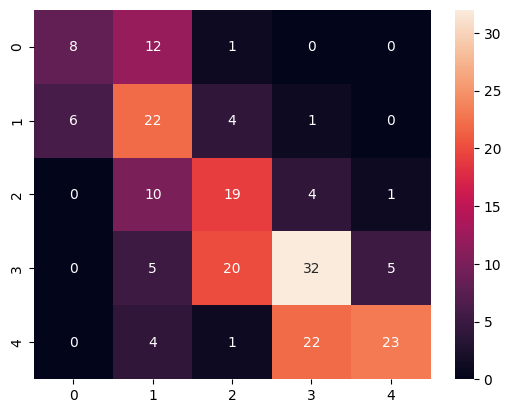

In [14]:
# confusion matrix
true_classes = yelp_ds_dict["test"]["label"]
preds_classes = np.argmax(preds.predictions, axis=1)
conf_mat = confusion_matrix(true_classes, preds_classes)
sns.heatmap(conf_mat, annot=True)

In [15]:
accuracy_score(true_classes, preds_classes)

0.52

In [16]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(yelp_ds_dict["train"]["label"], yelp_ds_dict["train"]["label"])

DummyClassifier(strategy='most_frequent')

In [17]:
dummy_clf.score(yelp_ds_dict["test"]["label"], yelp_ds_dict["test"]["label"])

0.165

In [18]:
model_cpu = model.to("cpu")
# Inference
with torch.no_grad():
    outputs = model_cpu(
        yelp_ds_dict["test"]["input_ids"], yelp_ds_dict["test"]["attention_mask"]
    )

In [19]:
# Loss calculation
pred_labels = torch.argmax(outputs.logits, dim=1)
loss = cross_entropy(outputs.logits, yelp_ds_dict["test"]["label"], reduction="none")

df_individual_reviews = (
    pd.DataFrame(
        {
            "text": yelp_ds_dict["test"]["text"],
            "label": yelp_ds_dict["test"]["label"],
            "pred_label": pred_labels,
            "loss": loss,
        }
    )
    .sort_values("loss", ascending=False)
    .reset_index(drop=True)
)
df_individual_reviews

,text,label,pred_label,loss
0,"My husband and I stopped going here, back in 2...",4,1,9.383715
1,This place has steadily improved over the year...,3,1,9.302185
2,"Ugh... I got a plate with seisage, tofu scramb...",0,1,8.524629
3,i was super excited to try quiet storm when i ...,1,3,8.499060
4,"Great pizza, reasonable prices, fast service -...",4,1,8.417213
...,...,...,...,...
195,"Worst tofu scramble ever. Days old, cold, hard...",0,0,0.000891
196,They have inaccurate hours posted. I tried to ...,0,0,0.000769
197,Lamb burger was outright bad(tasted off and ch...,1,1,0.000766
198,Three strikes and you're out! We had brunch t...,0,0,0.000738


<Axes: xlabel='label', ylabel='loss'>

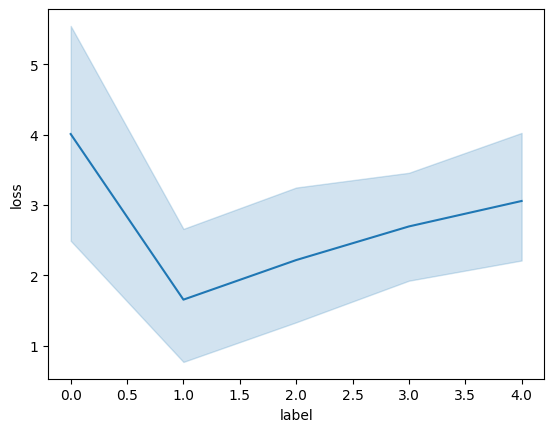

In [20]:
sns.lineplot(data=df_individual_reviews, x="label", y="loss")